In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import floris.tools as wfct
import floris.tools.visualization as vis
from floris.tools.optimization.scipy.yaw import YawOptimization

In [2]:
print("Running FLORIS with no yaw...")
# Instantiate the FLORIS object
file_dir = os.path.dirname(os.path.abspath('..'))
fi = wfct.floris_interface.FlorisInterface(
    os.path.join(file_dir, "examples/example_input.json")
)

Running FLORIS with no yaw...


In [3]:
# Set turbine locations to 3 turbines in a row
D = fi.floris.farm.turbines[0].rotor_diameter
layout_x = [0, 7 * D, 14 * D, 21 * D, 28 * D] * 5
layout_y = list(np.array([i * 3 * D for i in range(5)]).repeat(5, axis=0))
fi.reinitialize_flow_field(layout_array=(layout_x, layout_y),
                           wind_direction=270.0,
                           )
fi.calculate_wake()

In [4]:
# Initial power output
power_initial = fi.get_farm_power()
power_initial

32897369.52093389

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.


Plotting the FLORIS flowfield...


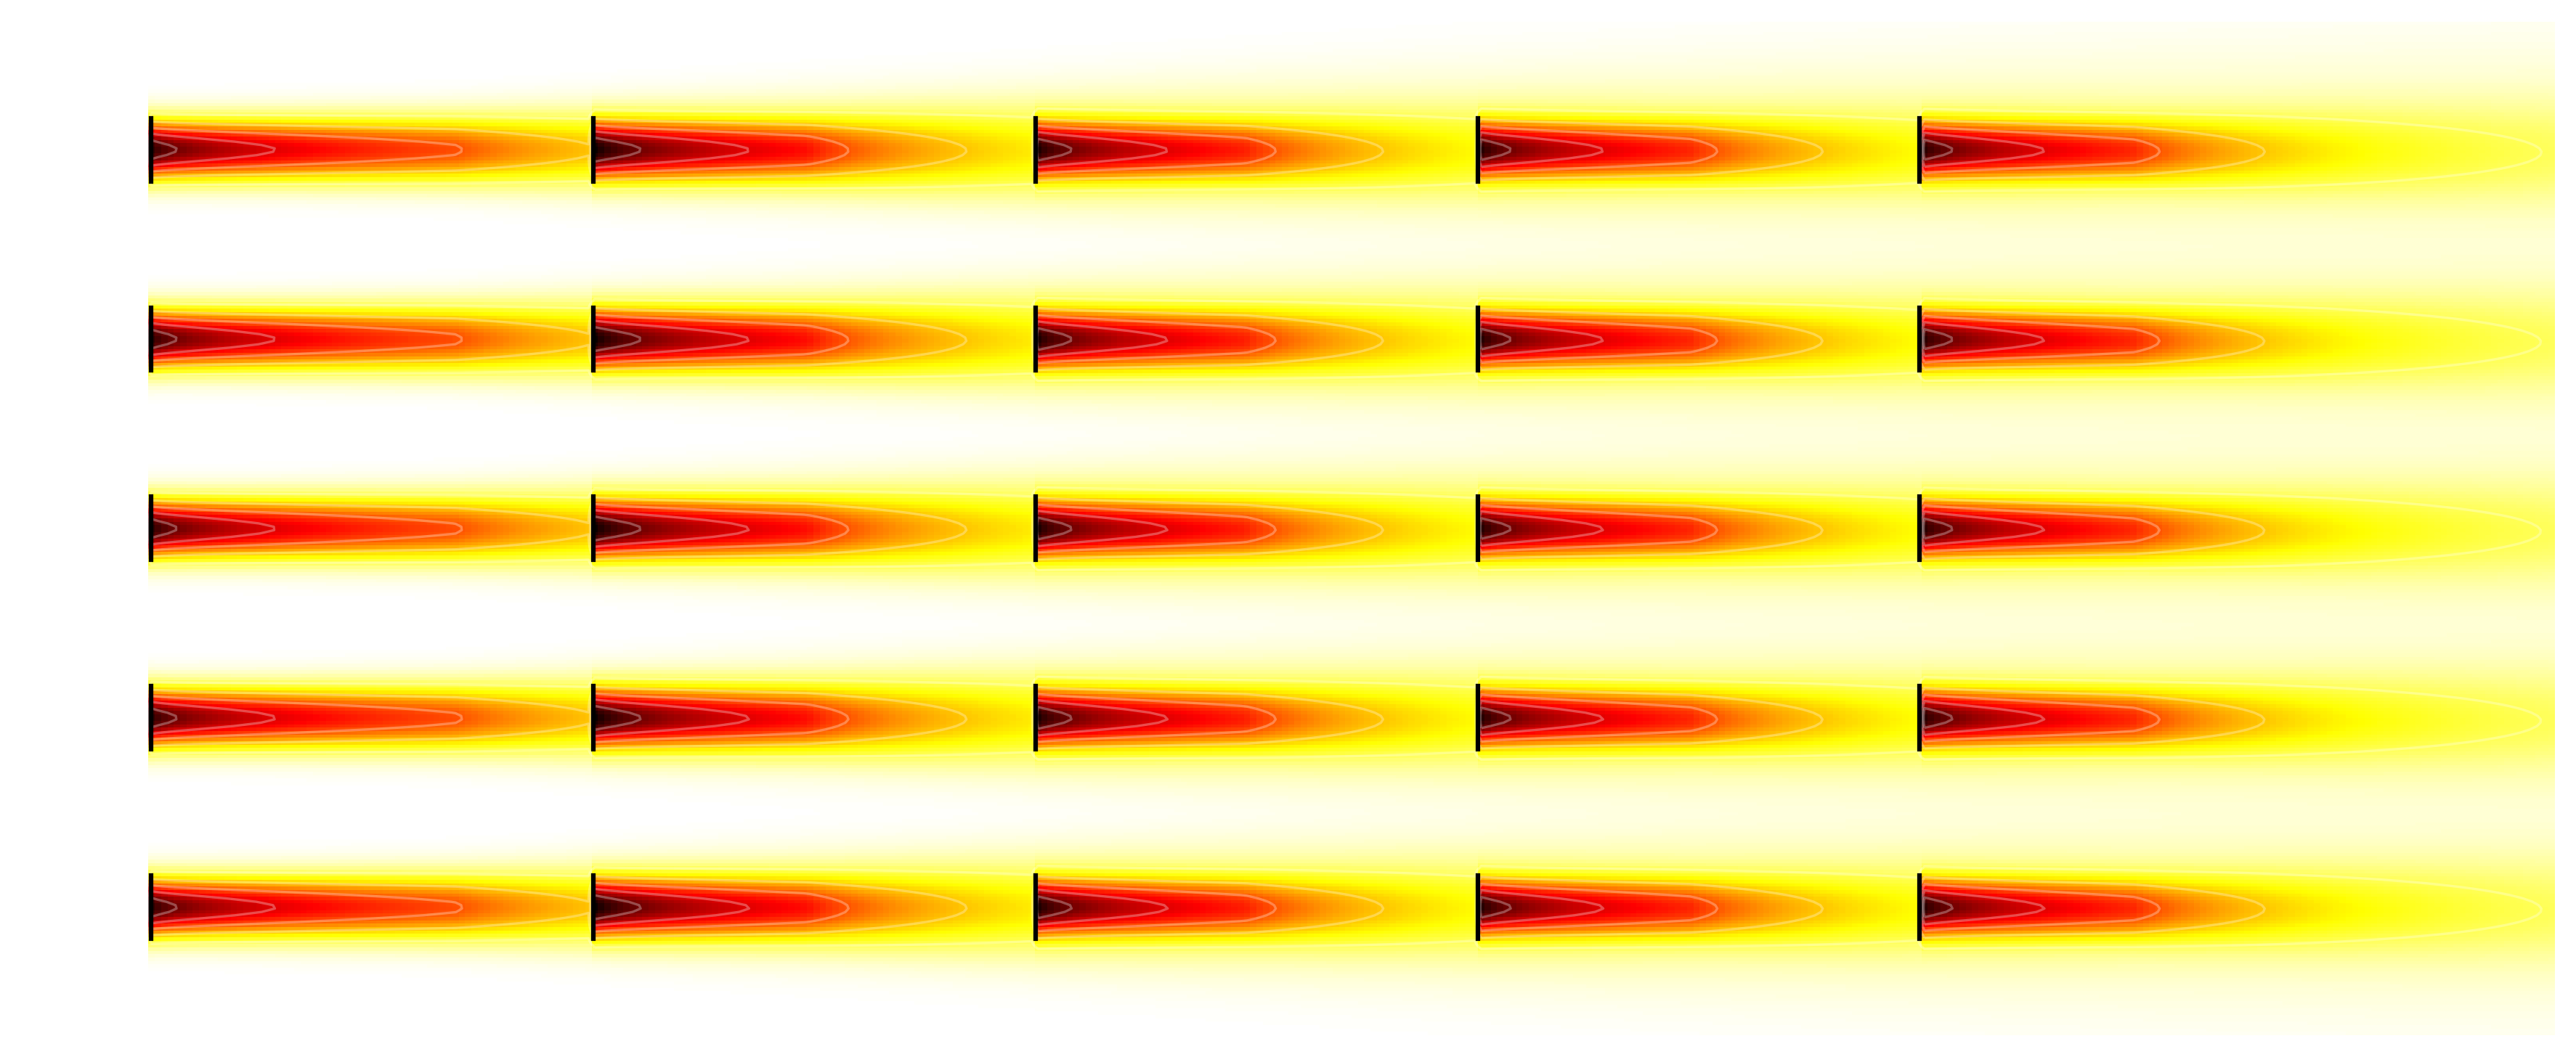

In [5]:
axis_visible = True
# =============================================================================
print("Plotting the FLORIS flowfield...")
# =============================================================================

# Initialize the horizontal cut
hor_plane = fi.get_hor_plane(x_resolution=400,
                             y_resolution=300,
                            #  x_bounds=[-150.0, 150.0],
                            #  y_bounds=[-200.0, 200.0],
                             )

# Plot and show
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
D = fi.floris.farm.turbine_map.turbines[0].rotor_diameter  # m
# hor_plane = wfct.cut_plane.rescale_axis(hor_plane, x1_factor=D, x2_factor=D)
wfct.visualization.visualize_cut_plane(hor_plane, ax=ax, cmap="hot")
vis.plot_turbines(
    ax,
    fi.layout_x,
    fi.layout_y,
    fi.get_yaw_angles(),
    D,
)
if not axis_visible:
    ax.set_title("Baseline Case for U = 8 m/s, Wind Direction = 270$^\\circ$")
    ax.set_xticks([i * 7 * D for i in range(5)])
    ax.set_xticklabels([str(i * 7) for i in range(5)])
    ax.set_yticks([-1.0 * D, 0.0, 1.0 * D])
    ax.set_yticklabels(["-1.0", "0", "1.0"])
else:
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')

In [6]:
# =============================================================================
print("Finding optimal yaw angles in FLORIS...")
# =============================================================================
# Set bounds for allowable wake steering
min_yaw = 0.0
max_yaw = 30.0

# options = None
options = {'maxiter': 20,
           'disp': True,
           'iprint': 2,
           'ftol': 1e-5,
           'eps': 0.01}

# Instantiate the Optimization object
yaw_opt = YawOptimization(fi,
                          minimum_yaw_angle=min_yaw,
                          maximum_yaw_angle=max_yaw,
                          opt_method="SLSQP",
                          opt_options=options,
                          )

Finding optimal yaw angles in FLORIS...


In [7]:
# Perform optimization
yaw_angles = yaw_opt.optimize()

print("==========================================")
print("yaw angles = ")
for i in range(len(yaw_angles)):
    print("Turbine ", i, "=", yaw_angles[i], " deg")

# Assign yaw angles to turbines and calculate wake
fi.calculate_wake(yaw_angles=yaw_angles)
power_opt = fi.get_farm_power()

print("==========================================")
print(
    "Total Power Gain = %.1f%%" % (100.0 * (power_opt - power_initial) / power_initial)
)
print("==========================================")

Optimizing wake redirection control...
Number of parameters to optimize =  25
  NIT    FC           OBJFUN            GNORM
    1    27    -1.000859E+00     2.886882E-02
    2    53    -1.008318E+00     3.334295E-02
    3    79    -1.175915E+00     5.921569E-02
    4   105    -1.269322E+00     1.171141E-01
    5   131    -1.270715E+00     2.276630E-02


KeyboardInterrupt: 

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.


Plotting the FLORIS flowfield with yaw...


[Text(0, -126.0, '-1.0'), Text(0, 0.0, '0'), Text(0, 126.0, '1.0')]

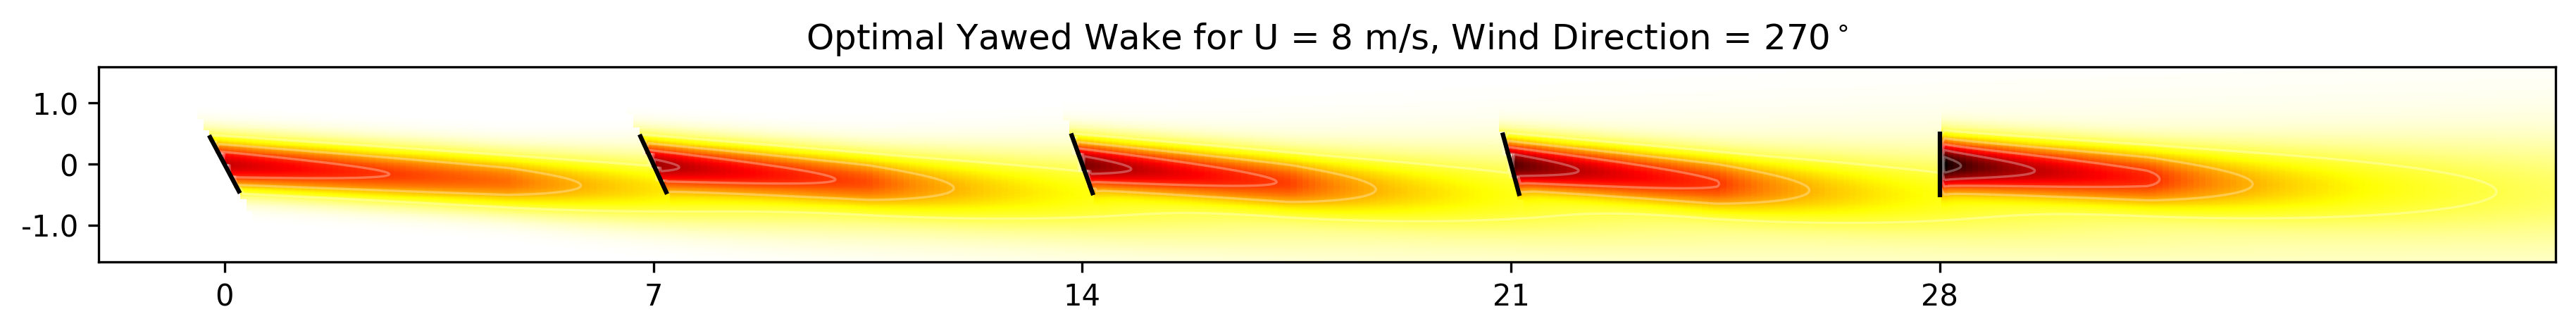

In [ ]:
axis_visible = True
# =============================================================================
print("Plotting the FLORIS flowfield with yaw...")
# =============================================================================

# Initialize the horizontal cut
hor_plane = fi.get_hor_plane(x_resolution=400,
                             y_resolution=300,
                             #  x_bounds=[-150.0, 150.0],
                            #  y_bounds=[-200.0, 200.0],
                             )

# Plot and show
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
D = fi.floris.farm.turbine_map.turbines[0].rotor_diameter  # m
# hor_plane = wfct.cut_plane.rescale_axis(hor_plane, x1_factor=D, x2_factor=D)
wfct.visualization.visualize_cut_plane(hor_plane, ax=ax, cmap="hot")
vis.plot_turbines(
    ax,
    fi.layout_x,
    fi.layout_y,
    fi.get_yaw_angles(),
    fi.floris.farm.turbine_map.turbines[0].rotor_diameter,
)
if not axis_visible:
    ax.set_title("Optimal Yawed Wake for U = 8 m/s, Wind Direction = 270$^\\circ$")
    ax.set_xticks([i * 7 * D for i in range(5)])
    ax.set_xticklabels([str(i * 7) for i in range(5)])
    ax.set_yticks([-1.0 * D, 0.0, 1.0 * D])
    ax.set_yticklabels(["-1.0", "0", "1.0"])
else:
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')

# plt.savefig("opt_yawed.png", format='png', bbox_inches='tight', dpi=150)
# plt.show()